In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.insert(0, "../../")

In [3]:
from jax import jit, vmap, grad
from jax.lax import scan
from jax.experimental.ode import odeint
from bosonic_jax import BosonicResults
import jaxquantum as jqt
import jax.numpy as jnp
import jax.scipy as jsp
import time
import matplotlib.pyplot as plt
import numpy as np

import seaborn as sns
# Apply the default theme
sns.set_theme()

from jax.config import config
config.update("jax_enable_x64", True)

# Manual sBs

In [4]:
N = 50
N_rounds = 20

In [5]:
@jit
def gen_GKP_basis_states(delta):
    
    # code params
    params = {}
    params["delta"] = delta
    params["l"] = 2.0 * jnp.sqrt(jnp.pi)
    s_delta = jnp.sinh(params["delta"] ** 2)
    params["epsilon"] = s_delta * params["l"]
    
    common_gates = {}
    
    common_gates["a"] = jqt.destroy(N)
    common_gates["a_dag"] = jqt.dag(common_gates["a"])
    common_gates["x"] = (common_gates["a_dag"] + common_gates["a"])/jnp.sqrt(2)
    common_gates["p"] = 1.0j*(common_gates["a_dag"] - common_gates["a"])/jnp.sqrt(2)
    
    common_gates["E"] = jsp.linalg.expm(- params["delta"] ** 2 * common_gates["a_dag"] @ common_gates["a"])
    common_gates["E_inv"] = jsp.linalg.expm(params["delta"] ** 2 * common_gates["a_dag"] @ common_gates["a"])
    
    x_axis = common_gates["x"]
    z_axis = -common_gates["p"]
    
    y_axis = x_axis + z_axis
    
    def _symmetrized_expm(op):
        return (jsp.linalg.expm(op) + jsp.linalg.expm(-1.0 * op)) / 2.0
    
    def _make_op_finite_energy(op):
        return common_gates["E"] @ op @ common_gates["E_inv"]
    
    common_gates["Z_s_0"] = _symmetrized_expm(
        1.0j * params["l"] / 2.0 * x_axis
    )
    common_gates["S_x_0"] = _symmetrized_expm(
        1.0j * params["l"] * z_axis
    )
    common_gates["S_z_0"] = _symmetrized_expm(
        1.0j * params["l"] * x_axis
    )
    common_gates["S_y_0"] = _symmetrized_expm(
        1.0j * params["l"] * y_axis
    )
    
    X_0 = jsp.linalg.expm(1.0j * params["l"] / 2.0 * z_axis)
    Z_0 = jsp.linalg.expm(1.0j * params["l"] / 2.0 * x_axis)
    Y_0 = 1.0j * X_0 @ Z_0
    
    common_gates["X"] = _make_op_finite_energy(X_0)
    common_gates["Y"] = _make_op_finite_energy(Y_0)
    common_gates["Z"] = _make_op_finite_energy(Z_0)
    
    H_0 = (
        - common_gates["S_x_0"]
        - common_gates["S_y_0"]
        - common_gates["S_z_0"]
        - common_gates["Z_s_0"]  # bosonic |+z> state
    )

    _, vecs = jnp.linalg.eigh(H_0)
    gstate_ideal = vecs[:, 0]

    # step 2: make ideal eigenvector finite energy
    gstate = common_gates["E"] @ gstate_ideal

    plus_z = jqt.unit(gstate).reshape(N, 1)
    minus_z = common_gates["X"] @ plus_z
    
    basis = {}
    
    basis["+z"] = plus_z.reshape(N, 1)
    basis["-z"] = minus_z.reshape(N, 1)

    basis["+x"] = jqt.unit(basis["+z"] + basis["-z"])
    basis["-x"] = jqt.unit(basis["+z"] - basis["-z"])
    basis["+y"] = jqt.unit(basis["+z"] + 1j * basis["-z"])
    basis["-y"] = jqt.unit(basis["+z"] - 1j * basis["-z"])
    return params, basis, common_gates

In [6]:
start = time.time()
GKP_params, GKP_basis, GKP_gates = gen_GKP_basis_states(0.25)
print("First Run Time (s): ", time.time() - start)

First Run Time (s):  10.63458514213562


In [7]:
%timeit gen_GKP_basis_states(0.25)

6.34 ms ± 342 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [8]:
@jit
def gen_gates(params, basis):
    """GKP + Stabilization Params"""
    l = params["l"]
    Δ = params["delta"]
    c = jnp.cosh(Δ**2)
    epsilon = params["epsilon"]


    """Useful Qubit Operators"""
    ρ_qubit_g = jqt.ket2dm(jqt.basis(2,0))
    ρ_qubit_e = jqt.ket2dm(jqt.basis(2,1))
    ρ_qubit_plus = jqt.ket2dm(jqt.unit(jqt.basis(2,0) + jqt.basis(2,1)))
    I_q = jqt.identity(2)

    """Useful Cavity Operators"""
    ρ_cavity_vac = jqt.ket2dm(jqt.coherent(N, 0))

    I_a = jqt.identity(N)
    a = jqt.destroy(N)
    q_a = (+1 * (a + jqt.dag(a)) / jnp.sqrt(2))
    p_a = (-1j * (a - jqt.dag(a)) / jnp.sqrt(2))



    """sBs Phase Estimation Unitaries"""

    M_z = jqt.expm(jqt.tensor(-1j * l * c * q_a / 4, jqt.sigmax())) @ jqt.expm(jqt.tensor(-1j * epsilon * p_a / 4, jqt.sigmay()))

    M_x = jqt.expm(jqt.tensor(-1j * l * c * p_a / 4, jqt.sigmax())) @ jqt.expm(jqt.tensor(+1j * epsilon * q_a / 4, jqt.sigmay()))

    M_y = jqt.expm(jqt.tensor(-1j * l * c * (q_a + p_a) / 4, jqt.sigmax())) @ jqt.expm(jqt.tensor(-1j * epsilon * (p_a - q_a) / 4, jqt.sigmay()))
    
    
    def gen_CD(beta):
        return (jqt.tensor(1.0j * (beta * jqt.dag(a) - jnp.conj(beta) * a) / jnp.sqrt(2), jqt.sigmaz() / 2), jnp.linspace(0, 1, 101))
    
    def gen_RX(omega):
        return (jqt.tensor(I_a, jqt.sigmax() * omega / 2), jnp.linspace(0, jnp.pi / 2, 101))
        
    circs = {"x":([],[]), "p":([],[])}

    # bcirc_x
    gate, ts = gen_CD(epsilon/2)
    circs["x"][0].append(gate)
    circs["x"][1].append(ts)
    
    gate, ts = gen_RX(1)
    circs["x"][0].append(gate)
    circs["x"][1].append(ts)
    
    gate, ts = gen_CD(-1.0j*l)
    circs["x"][0].append(gate)
    circs["x"][1].append(ts)
    
    gate, ts = gen_RX(-1)
    circs["x"][0].append(gate)
    circs["x"][1].append(ts)
    
    gate, ts = gen_CD(epsilon/2)
    circs["x"][0].append(gate)
    circs["x"][1].append(ts)
    
    # bcirc_p
    gate, ts = gen_CD(1.0j*epsilon/2)
    circs["p"][0].append(gate)
    circs["p"][1].append(ts)
    
    gate, ts = gen_RX(1)
    circs["p"][0].append(gate)
    circs["p"][1].append(ts)
    
    gate, ts = gen_CD(1.0j*(-1.0j*l))
    circs["p"][0].append(gate)
    circs["p"][1].append(ts)
    
    gate, ts = gen_RX(-1)
    circs["p"][0].append(gate)
    circs["p"][1].append(ts)
    
    gate, ts = gen_CD(1.0j*epsilon/2)
    circs["p"][0].append(gate)
    circs["p"][1].append(ts)
    
    resources = {}
    A = jqt.tensor(jqt.displace(N, .35449077), I_q) # small init displacement
    pGKP_plusz = jqt.tensor(basis["+z"], jqt.basis(2,0))
    resources["p0"] = jqt.ket2dm(A @ pGKP_plusz)
    return circs, resources

In [9]:
start = time.time()
sBs_circs, sBs_resources = gen_gates(GKP_params, GKP_basis)
print("First Run Time (s): ", time.time() - start)

First Run Time (s):  1.7302966117858887


In [10]:
@jit
def gate_step(gate, p0, H0, c_ops):
    H1 = gate[0]
    ts = gate[1]
    
    def H_func(rho, t, H0_val, H1_val, c_ops_val):
        H = H0 + H1
        rho_dot = -1.0j*(H @ rho - rho @ H)
        return rho_dot
    states = odeint(H_func, p0, ts, H0, H1, c_ops)
    return states

@jit
def execute(circ, p0, H0, c_ops):
    def execute_step(rho, gate):
        states = gate_step(gate, rho, H0, c_ops)
        return states[-1], states
    num_gates = len(circ)
    _, results = scan(execute_step, p0, (jnp.array(circ[0]),jnp.array(circ[1])))#jnp.arange(num_gates), length=num_gates)
    return results

In [69]:
@jit
def test(p0, _):
    N_size = 50
    H1 = jqt.num(N_size) + 0.0j
    ts = jnp.linspace(0, 1, 101)
    gate = (H1, ts)
    H0 = jqt.destroy(N_size) + jqt.create(N_size) + 0.0j
    c_ops = jnp.array([])
    results = gate_step(gate, p0, H0, c_ops)
    return results[-1], results

@jit
def test_multi(p0):
    return scan(test, p0, None, length=100)

In [70]:
p0 = jqt.ket2dm(jqt.coherent(50,20))

In [71]:
%timeit -n1 -r1 test(p0 + 0.0j, None)
%timeit test(p0 + 0.0j, None)

862 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
67.4 ms ± 1.19 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [82]:
@jit
def tg(a):
    return jnp.real(test(a*p0 + 0.0j, None)[0][0][0])

In [83]:
%timeit -n1 -r1 grad(tg)(1.0)
%timeit grad(tg)(1.0)

2.86 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
1.22 s ± 325 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [72]:
%timeit -n1 -r1 test_multi(p0 + 0.0j)
%timeit test_multi(p0 + 0.0j)

7.5 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
6.89 s ± 435 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [59]:
%timeit -n1 -r1 test_multi(p0 + 0.0j)

347 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [33]:
%timeit test(p0 + 0.0j)

65.9 ms ± 1.55 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [11]:
@jit
def run_sBs(circs, resources, GKP_gates, H0, c_ops):
    single_qubit_g = jqt.ket2dm(jqt.basis(2,0))
    plus = jqt.ket2dm(1 / jnp.sqrt(2) * (jqt.basis(2, 0) + jqt.basis(2, 1)))
    meas_ops = jnp.array([GKP_gates["X"], GKP_gates["Y"], GKP_gates["Z"]])
    rho = resources["p0"]
    trace_dims = (N,2)        
    
    def sBs_stabilize_meas(rho_i):
        def measure_logical(M):
            return jqt.tr(M @ jqt.ptrace(rho_i, 0, trace_dims))
        return vmap(measure_logical)(meas_ops)
    
    def sBs_stabilize_circ(rho_i):
        results = execute(circs["x"], jqt.tensor(jqt.ptrace(rho_i, 0, trace_dims), plus), H0, c_ops) 
        rho_i = results[-1][-1]
        results = execute(circs["p"], jqt.tensor(jqt.ptrace(rho_i, 0, trace_dims), plus), H0, c_ops) 
        rho_i = results[-1][-1]
        return rho_i
        
    def run_sBs_round(rho_i, _ ):
        meas_result = sBs_stabilize_meas(rho_i)
        rho_i = sBs_stabilize_circ(rho_i)
        return rho_i, meas_result
        
    _, meas_results = scan(run_sBs_round, rho, None, length=N_rounds)
    return meas_results

In [12]:
start = time.time()
sBs_meas_results = run_sBs(sBs_circs, sBs_resources, GKP_gates, 0.0, jnp.array([]))
print("First Run Time (s): ", time.time() - start)

First Run Time (s):  13.40997314453125


In [13]:
%timeit run_sBs(sBs_circs, sBs_resources, GKP_gates, 0.0, jnp.array([]))

11.2 s ± 530 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


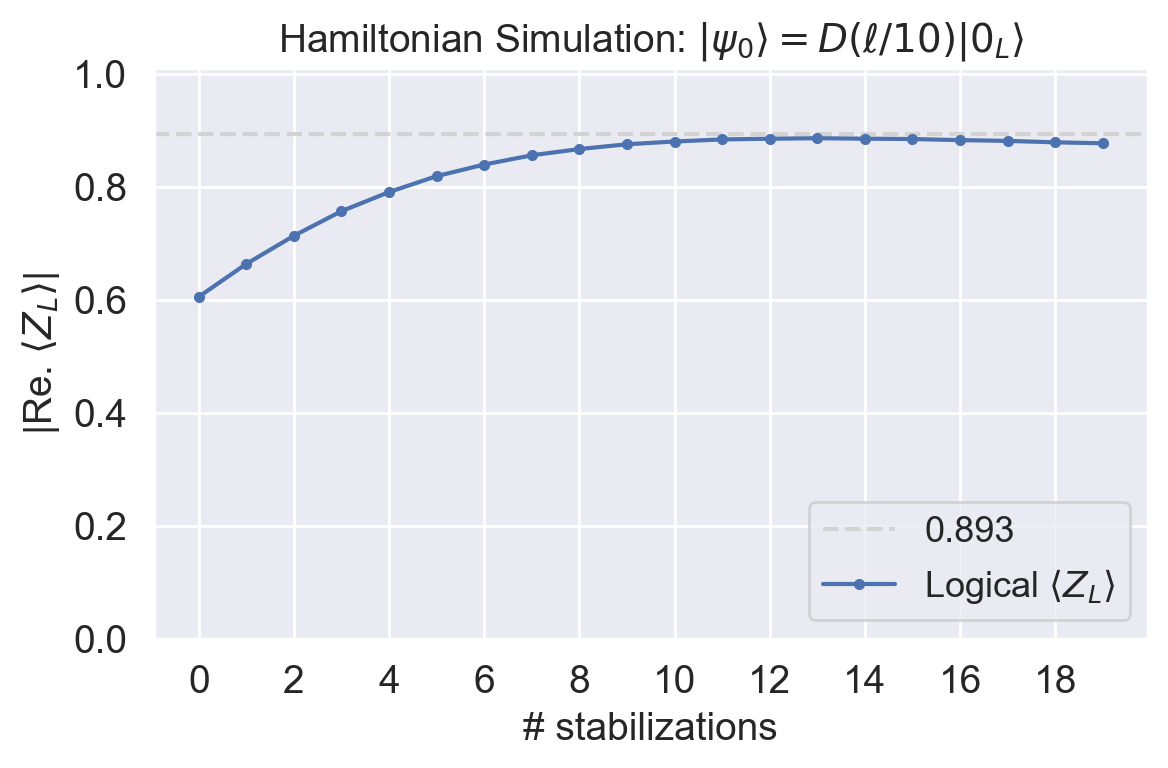

In [14]:
plt.figure("logicals", dpi=200)
plt.clf()
plt.axhline(0.893, linestyle="dashed", color="lightgray", label="0.893")
plt.plot(np.abs(np.real(sBs_meas_results[:, 2])), '.-', label=r"Logical $\langle Z_L \rangle$")
plt.ylim(0, 1.01)
plt.title(fr"Hamiltonian Simulation: $|\psi_0\rangle = D\left(\ell/10\right)|0_L\rangle$", fontsize=14)
plt.legend(loc='lower right', fontsize=13)
plt.xlabel("# stabilizations", fontsize=14)
plt.xticks(np.arange(0, 20, 2), fontsize=14)
plt.yticks(fontsize=14)
plt.ylabel(r"|Re. $\langle Z_L \rangle$|", fontsize=14)
plt.tight_layout()
plt.show()

In [17]:
start = time.time()
sBs_meas_results = jit(run_sBs)(sBs_circs, sBs_resources, GKP_gates, 0.0, jnp.array([]))
print("First Run Time (s): ", time.time() - start)

First Run Time (s):  12.708683967590332


# Testing

In [ ]:
f = jit(gen_GKP_basis_states)

@jit
def test():
    for i in range(5):
        gen_GKP_basis_states(0.25)

@jit
def test2():
    for i in range(5):
        f(0.25)
        

def test3():
    for i in range(5):
        f(0.25)
    
@jit
def test4():
    deltas = jnp.ones(5)*.25
    vmap(gen_GKP_basis_states)(deltas)
    
@jit
def test5():
    deltas = jnp.ones(5)*.25
    vmap(f)(deltas)
    
def test6():
    deltas = jnp.ones(5)*.25
    vmap(f)(deltas)
    

In [ ]:
start = time.time()
test()
print("First Run Time (s): ", time.time() - start)

First Run Time (s):  20.021356105804443


In [52]:
start = time.time()
test3()
print("First Run Time (s): ", time.time() - start)

First Run Time (s):  13.540022134780884


In [53]:
start = time.time()
test2()
print("First Run Time (s): ", time.time() - start)

First Run Time (s):  20.538008213043213


In [56]:
start = time.time()
test4()
print("First Run Time (s): ", time.time() - start)

First Run Time (s):  4.295015811920166


In [57]:
start = time.time()
test5()
print("First Run Time (s): ", time.time() - start)

First Run Time (s):  4.043358087539673


In [ ]:
start = time.time()
test6()
print("First Run Time (s): ", time.time() - start)

First Run Time (s):  27.728702068328857
